# Transfer Learning

(or Green Deep Learning!)

What is transfer learning?
Transfer learning (TL) is a technique in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different problem.

We start from a pre-trained model which is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You can either use the pretrained model as is or use transfer learning to customize this model to a given task!


Why use it?
- Minimize training time
- Lower emissions 
- More powerful feature extractors 

![title](https://ekamperi.github.io/images/compute_diagram.png)
https://developer.nvidia.com/blog/training-bert-with-gpus/

![title](https://ekamperi.github.io/images/nvidia_training.jpg)

https://developer.nvidia.com/blog/training-bert-with-gpus/

![title](https://ekamperi.github.io/images/footprint_comparison.png)


### Costs:
- 2.5k – 50k USD (110 million parameter model)
- 10k – 200k USD(340 million parameter model)
- 80k – 1.6m USD (1.5 billion parameter model)
source: syncedreview.com


Here we will try two ways to customize a pretrained model:

1. Feature Extraction (als covered in last tutorial)
2. Fine-Tuning 

Let's get started

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
#downloading the data
# We will use a dataset containing several thousand images of cats and dogs
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)


In [3]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


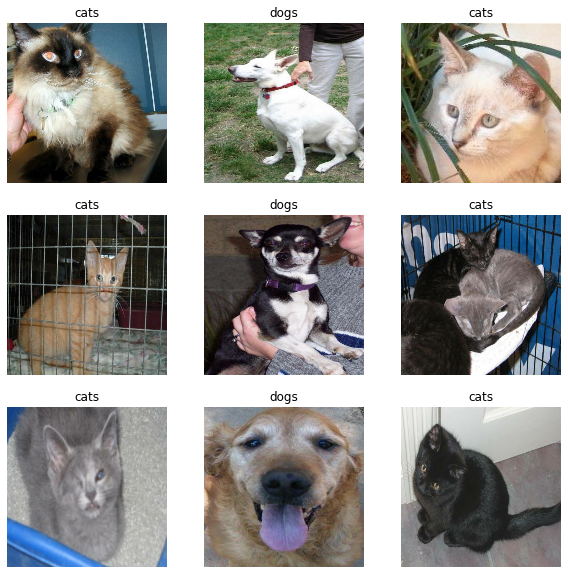

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
#The dataset does not have a test set so ww will use 20% of the valudation set into testing
#Training is 2000 and validation is 1000 (too large for validation only!)

#Only run once
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [8]:
#Use buffered prefetching to load images from disk without having I/O become blocking
#https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
#When you don't have a large image dataset, 
#it's a good practice to artificially introduce sample diversity by applying random, 
#yet realistic, transformations to the training images,
#such as rotation and horizontal flipping.
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),])

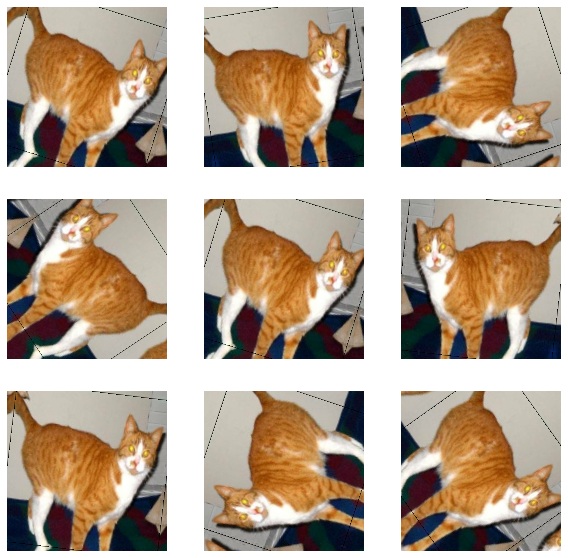

In [10]:
#Let's repeatedly apply these layers to the same image and see the result.

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
#Rescale pixel values 
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
# Create the base model from the pre-trained model MobileNet V2 developed at Google
# https://arxiv.org/pdf/1704.04861.pdf
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# 32 = batch size

(32, 5, 5, 1280)


In [14]:
#Freeze the convolutional base (you are not fine tuning here)
base_model.trainable = False

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
#Apply a tf.keras.layers.Dense layer to convert these features 
#into a single prediction per image
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API.

In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Compile the model before training it

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

Note: The 2.5M parameters in MobileNet are frozen, but there are 1.2K trainable parameters in the Dense layer!

In [21]:
len(model.trainable_variables)

2

Let's see the validation performance before training!

In [23]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 7s 252ms/step - loss: 0.7692 - accuracy: 0.4938


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.77
initial accuracy: 0.49


In [25]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 32s 509ms/step - loss: 0.7555 - accuracy: 0.5415 - val_loss: 0.5432 - val_accuracy: 0.6683
Epoch 2/10
63/63 [==============================] - 32s 514ms/step - loss: 0.5748 - accuracy: 0.6780 - val_loss: 0.3961 - val_accuracy: 0.7995
Epoch 3/10
63/63 [==============================] - 33s 530ms/step - loss: 0.4502 - accuracy: 0.7625 - val_loss: 0.3151 - val_accuracy: 0.8564
Epoch 4/10
63/63 [==============================] - 34s 539ms/step - loss: 0.3880 - accuracy: 0.8190 - val_loss: 0.2609 - val_accuracy: 0.8787
Epoch 5/10
63/63 [==============================] - 34s 533ms/step - loss: 0.3395 - accuracy: 0.8410 - val_loss: 0.2262 - val_accuracy: 0.9010
Epoch 6/10
63/63 [==============================] - 32s 500ms/step - loss: 0.3005 - accuracy: 0.8655 - val_loss: 0.1901 - val_accuracy: 0.9270
Epoch 7/10
63/63 [==============================] - 32s 507ms/step - loss: 0.2800 - accuracy: 0.8745 - val_loss: 0.1822 - val_accuracy: 0.9344

Let's now look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor!

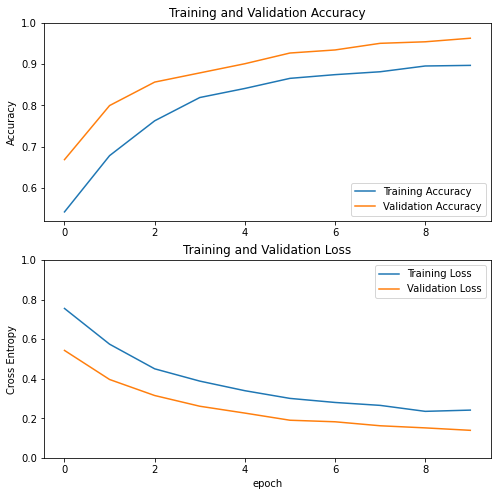

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine-tuning!

In the feature extraction experiment, you were only training a few layers on top (classification layers) of an MobileNet V2 base model. The weights of the (CNN part)pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added.


Let's un-freeze the top layers of the model!

In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

Note: number of trainable paramters now jumped to ~1.

What's the none-trainable prameters?
Other paramters associated with the model:
- Input shape
- The number of hidden layers itself 
- Nodes on each hidden layer
- Statistics in BatchNormalization layers and other operation layers 
- any paramter not updated by gradient descent!

In [31]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 36s 574ms/step - loss: 0.1644 - accuracy: 0.9275 - val_loss: 0.0954 - val_accuracy: 0.9703
Epoch 11/20
63/63 [==============================] - 44s 704ms/step - loss: 0.1304 - accuracy: 0.9490 - val_loss: 0.0537 - val_accuracy: 0.9851
Epoch 12/20
63/63 [==============================] - 46s 723ms/step - loss: 0.1237 - accuracy: 0.9490 - val_loss: 0.0566 - val_accuracy: 0.9740
Epoch 13/20
63/63 [==============================] - 46s 735ms/step - loss: 0.1102 - accuracy: 0.9595 - val_loss: 0.0523 - val_accuracy: 0.9864
Epoch 14/20
63/63 [==============================] - 40s 633ms/step - loss: 0.0997 - accuracy: 0.9660 - val_loss: 0.0407 - val_accuracy: 0.9876
Epoch 15/20
63/63 [==============================] - 40s 635ms/step - loss: 0.0936 - accuracy: 0.9625 - val_loss: 0.0412 - val_accuracy: 0.9851
Epoch 16/20
63/63 [==============================] - 46s 727ms/step - loss: 0.0821 - accuracy: 0.9700 - val_loss: 0.0405 - val_accuracy:

We see the difference now!


Let's check the validation accuracy!

In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

Let's visulize the before and after fine-tuning perfromance!

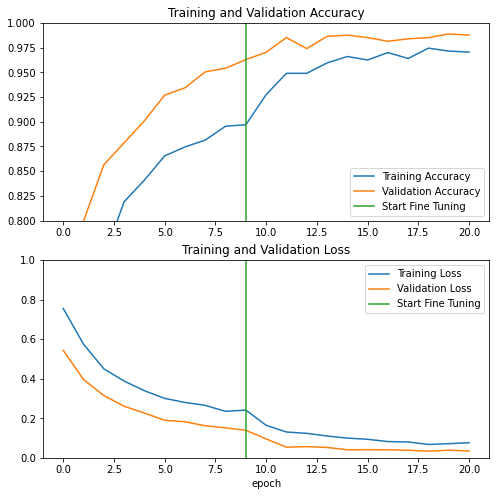

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Finaly let's look at the test performance

In [34]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 229ms/step - loss: 0.0333 - accuracy: 0.9844
Test accuracy : 0.984375


The model is now ready for predicting if your pet is a cat or dog.

Predictions:
 [1 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0]
Labels:
 [1 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0]


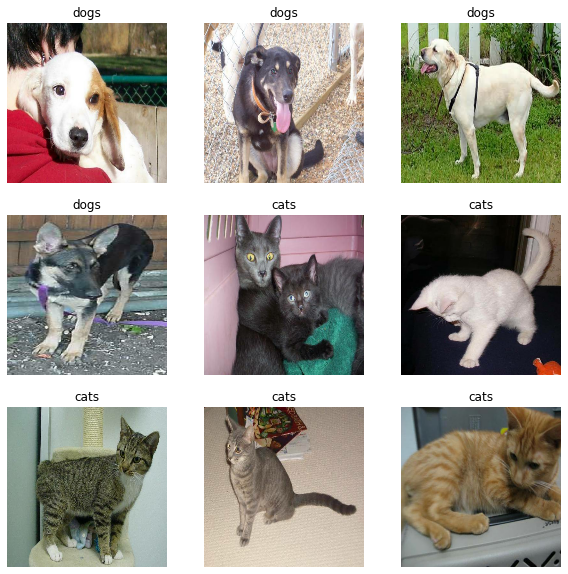

In [35]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Part 2: Transfer learning with TensorFlow Hub

Instead of being  limited to keras applications https://www.tensorflow.org/api_docs/python/tf/keras/applications. The TensorFlow Hub lets you search and discover hundreds of trained, ready-to-deploy machine learning models in one place!


Let's demonstrate its use!

In [36]:
#Just in case you need to download it!
!pip install tensorflow_hub 

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [37]:
#Setup 
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

Let's start with ImageNet by using a pretrained classifer model to take an image and predict what it's an image of - no training required!

In [38]:
IMAGE_SHAPE = (224, 224)
model='https://tfhub.dev/tensorflow/efficientnet/b0/classification/1'
classifier = tf.keras.Sequential([
    hub.KerasLayer(model, input_shape=IMAGE_SHAPE+(3,))])

Using TensorFlow backend.


Download a single image to apply the model on

65536/61306 [================================] - 0s 1us/step


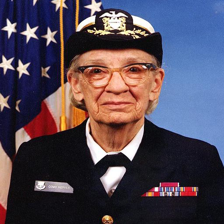

In [39]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [40]:
#Manual normalization
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [41]:
#Add a batch dimension, and pass the image to the model
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1000)

In [42]:
predicted_class = np.argmax(result[0], axis=-1)+1
predicted_class

653

In [43]:
#Take the predicted class ID and fetch the ImageNet labels to decode the predictions
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 1us/step


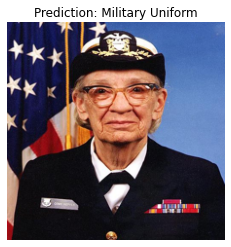

In [44]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Full example 
What if you want to train  transfer learninga classifier for a dataset with different classes?

In [45]:
#Let's download the data
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 8s 0us/step


In [46]:
#Let's load this data into our model using images off disk using image_dataset_from_directory.

batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [47]:
#We have five different flower classes
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [48]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [50]:
# Let's no make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking.
# These are two important methods you should use when loading data.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [51]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [52]:
# Run classifier
#NOTE: It takes some time!
result_batch = classifier.predict(train_ds)

In [53]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['rapeseed', 'pop bottle', 'scuba diver', ..., 'rapeseed',
       'rapeseed', 'bell pepper'], dtype='<U30')

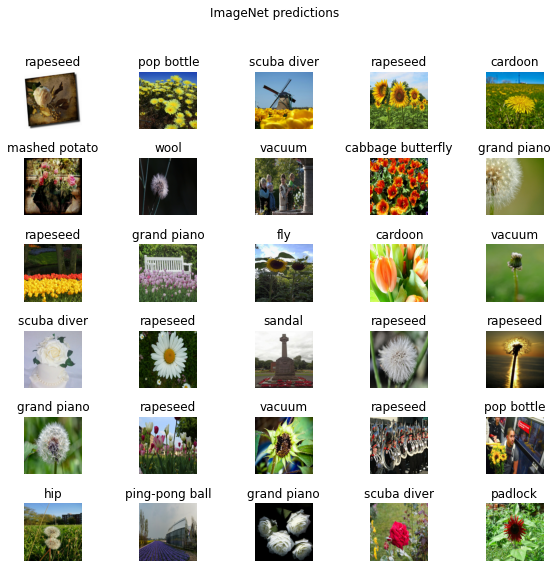

In [54]:
#Now check how these predictions line up with images
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [55]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [56]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [57]:
#It returns a 1280-length vector of features for each image:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [58]:
# Let's wrap the model layer in a tf.keras.Sequential model,
# and add a new classification layer!
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


Note: we are freezing feature extraction layers here too!

In [59]:
predictions = model(image_batch)

In [60]:
predictions.shape

TensorShape([32, 5])

In [61]:
#Let's train the model
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [62]:
# Helper functions to visulize the training progress 

class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=2,
                    callbacks=[batch_stats_callback])

Epoch 1/2
92/92 [==============================] - 52s 564ms/step - loss: 0.5531 - acc: 0.8333
Epoch 2/2
92/92 [==============================] - 52s 570ms/step - loss: 0.3346 - acc: 0.8333


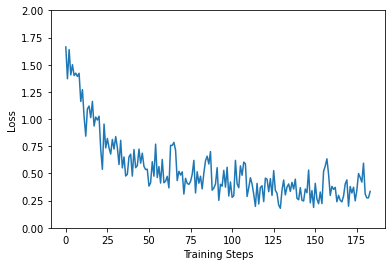

In [63]:
# Let's check the progress on the loss
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

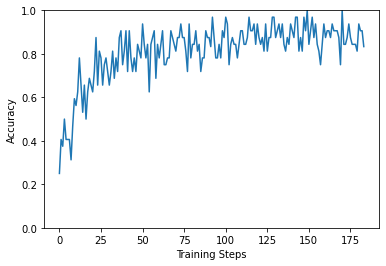

In [64]:
# Let's check the progress on the accuracy
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [65]:
# Let's check the predictions now

predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

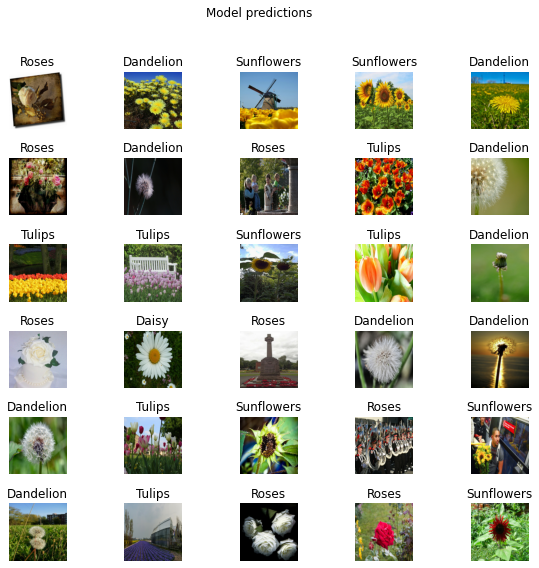

In [66]:
# plot

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

### Important: how to export your model!

In [67]:
t = time.time()

export_path = "".format(int(t))
model.save(export_path)

export_path

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


''

Now confirm that we can reload it, and it still gives the same results:

In [68]:
reloaded = tf.keras.models.load_model(export_path)

In [69]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [70]:
abs(reloaded_result_batch - result_batch).max()

0.0

Same!!

References:
    - François Chollet
    - https://www.tensorflow.org/